In [1]:

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt


from config import ModelConfig, TrainingConfig, HardwareConfig, DataConfig

import xarray as xr
import torch

import pandas as pd

import os
import glob
import re
from tqdm import tqdm
import plotly.io as pio

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


import seaborn as sns

from VAE_GMM import VAE
from dataset import CustomDataset, DataModule
from sklearn.mixture import GaussianMixture
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib as mpl




mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 11,      # Schriftgröße Achsenbeschriftung
    "axes.titlesize": 11,      # Schriftgröße Titel
    "axes.linewidth": 0.5,     # Achsenlinienbreite
    "lines.linewidth": 0.5,    # Linienbreite
    "font.size": 11,           # Grundschriftgröße
    "legend.fontsize": 11,     # Legende
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    # tick_direction
    "xtick.direction": "in",
    "ytick.direction": "in",
    #"figure.figsize": (5.7, 3.5),  # z.B. 145mm x 90mm in inch
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "pgf.preamble": "\n".join([
        r"\usepackage[T1]{fontenc}",
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[english]{babel}"
    ]),
})


text_width_mm = 145
inches_per_mm = 1/25.4
fig_width_in = text_width_mm * inches_per_mm
fig_height_in = fig_width_in * 0.6

In [2]:
def gather_data(loader):
    """Sammelt alle Batches und gibt ein numpy-Array (N,1,lat,lon) zurück."""
    arrs = []
    with torch.no_grad():
        for xb, _ in tqdm(loader, desc="Loading data"):
            arrs.append(xb)
    data = torch.cat(arrs, dim=0).cpu().numpy()
    return data

def compute_pca_kmeans_baseline(
    train_data, val_data,
    n_components=10, n_clusters=5, seed=42,
    k_smooth=10
):
    """
    PCA (fit auf Train), KMeans (fit auf Train, predict auf Val),
    Rekonstruktions-MSE und Cluster-Metriken + optional Smoothness.
    """
    flat_train = train_data[:,0].reshape(train_data.shape[0], -1)
    flat_val   = val_data [:,0].reshape(val_data.shape[0],  -1)

    # PCA auf train
    pca = PCA(n_components=n_components, whiten=False)
    scores_train = pca.fit_transform(flat_train)
    scores_val   = pca.transform(flat_val)

    # KMeans auf train
    kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=seed)
    kmeans.fit(scores_train)
    labels_val = kmeans.predict(scores_val)

    # Rekonstruktions-MSE auf Val
    recon_val = pca.inverse_transform(scores_val)
    recon_train = pca.inverse_transform(scores_train)
    loss_recon = float(np.mean((flat_val - recon_val)**2))
    
    # Balance
    
    n_clusters = kmeans.n_clusters
    # One-Hot-Encoding für harte Zuweisung
    gamma = np.zeros((len(labels_val), n_clusters), dtype=np.float32)
    gamma[np.arange(len(labels_val)), labels_val] = 1.0
    gamma_torch = torch.from_numpy(gamma)
    balance = float(cluster_balance_metric(gamma_torch).item())

    # Cluster-Metriken auf Val
    sil = float(silhouette_score(scores_val, labels_val))
    cal = float(calinski_harabasz_score(scores_val, labels_val))
    db  = float(davies_bouldin_score(scores_val, labels_val))
    ps  = np.bincount(labels_val) / labels_val.size
    ent = float(-np.sum(ps * np.log(ps + 1e-10)))
    scores_std = (scores_val - scores_val.mean(axis=0)) / (scores_val.std(axis=0) + 1e-10)
    z_torch = torch.from_numpy(scores_std).float()
    smooth, density_var, gauss_sim = compute_smoothness(z_torch, k=k_smooth)

    baseline_raw = {
        "loss_recon":          loss_recon,
        "silhouette":          sil,
        "calinski_harabasz":   cal,
        "davies_bouldin":      db,
        "cluster_entropy":     ent,
        "smoothness":          smooth,
        "density_variation":   density_var,
        "gaussian_similarity": gauss_sim,
        "balance":             balance,
    }

    return baseline_raw, pca, scores_val


def compute_smoothness(z: torch.Tensor, k: int = 10):
    """
    Deine VAE-Smoothness-Funktion auch für PCA-Scores.
    Erwartet z bereits zero-centered und unit-std.
    Liefert smoothness, density_variation, gaussian_similarity.
    """
    distances = torch.cdist(z, z)
    knn, _ = torch.topk(distances, k, largest=False)
    density_variation = torch.std(knn[:,1:])
    z_std = torch.std(z, dim=0)
    gaussian_similarity = -torch.mean(torch.abs(z_std - 1.0))
    smoothness = -density_variation + gaussian_similarity
    return float(smoothness), float(density_variation), float(gaussian_similarity)

def cluster_balance_metric(gamma, threshold_factor=0.5):
        """
        Bewertet die Clusterverteilung und bestraft schrumpfende Cluster.

        Args:
            gamma (Tensor): Soft Assignments (batch_size, num_clusters)
            threshold_factor (float): Schwelle, ab der Cluster als geschrumpft gelten
            epsilon (float): Numerische Stabilität

        Returns:
            Tensor: Score (höher ist besser)
        """
        # 1. Clustergrößen berechnen
        cluster_sizes = gamma.sum(0)  # Anzahl der Zuweisungen je Cluster
        avg_cluster_size = cluster_sizes.mean()  # Durchschnittliche Clustergröße

        # 2. Shrinkage Penalty: Strafe für Cluster < threshold_factor * Durchschnitt
        shrinkage_penalty = torch.sum(torch.relu((threshold_factor * avg_cluster_size) - cluster_sizes))

        # 3. Balance Penalty: Strafe für unausgewogene Cluster (Standardabweichung)
        balance_penalty = torch.std(cluster_sizes)

        # 4. Kombinierter Score (je kleiner, desto schlechter)
        score = - (balance_penalty + 5.0 * shrinkage_penalty)

        return score  # Höherer Score = besseres Clustering

def load_vae_metrics_tensorboard(base_logs, experiments, metric_tags):
    """
    Lädt für jede (exp_name,version) den letzten Wert aller metric_tags aus TB.
    Gibt DataFrame mit Spalten exp_name, version und Metriken zurück.
    """
    from tb_utils import load_tensorboard_scalars
    records = []
    for exp_name, versions in experiments.items():
        for v in versions:
            logdir = os.path.join(base_logs, exp_name, f"version_{v}")
            row = {"exp_name": exp_name, "version": v}
            for m, tag in metric_tags.items():
                try:
                    _, vals, _ = load_tensorboard_scalars(logdir, tag)
                    row[m] = float(vals[-1])
                except Exception:
                    row[m] = np.nan
            records.append(row)
    return pd.DataFrame(records)


def compute_norm_bounds(
    df: pd.DataFrame,
    keys: list[str],
    fixed_min: dict[str,float] | None = None,
    fixed_max: dict[str,float] | None = None
) -> tuple[dict[str,float], dict[str,float]]:
    """
    Liefert für jede Metrik in `keys` ein (min,max)-Paar.
    - Wenn `fixed_min` und `fixed_max` gegeben sind, werden diese zurückgegeben.
    - Ansonsten werden sie aus df[keys] per df.min()/df.max() ermittelt.
    """
    if fixed_min is not None and fixed_max is not None:
        # vollständige Übernahme der festen Grenzen
        return fixed_min.copy(), fixed_max.copy()
    # dynamisch aus den Daten berechnen
    gmin = df[keys].min().to_dict()
    gmax = df[keys].max().to_dict()
    return gmin, gmax


def prepare_radar_df(
    df: pd.DataFrame,
    keys: list[str],
    invert_keys: list[str],
    top_n: int | None = None,
    baseline_raw: dict[str, float] | None = None,
    norm_source_df: pd.DataFrame | None = None,
    fixed_min: dict[str, float] | None = None,
    fixed_max: dict[str, float] | None = None,
    baseline_name: str = "PCA+KMeans"
) -> pd.DataFrame:
    df_work = df.copy()

    # 1) Baseline anhängen (nur falls baseline_raw übergeben!)
    if baseline_raw is not None:
        row = {"exp_name": baseline_name, "version": np.nan}
        for k, v in baseline_raw.items():
            if isinstance(v, (int, float, np.number, np.floating, np.integer)):
                row[k] = float(v)
            elif isinstance(v, pd.Series):
                row[k] = float(v.item())
            elif isinstance(v, (np.generic, np.ndarray)):
                row[k] = float(v.item())
            else:
                row[k] = v  # String oder sonst was: einfach übernehmen!
        df_work = pd.concat([df_work, pd.DataFrame([row])], ignore_index=True)

    # 2) Nach dem Anhängen: Alle relevanten Spalten auf float casten!
    for k in keys:
        df_work[k] = pd.to_numeric(df_work[k], errors='coerce')

    # 3) Top-N Auswahl
    if top_n is not None:
        mask = df_work["exp_name"] != baseline_name
        top_idx = df_work[mask].nlargest(top_n, "silhouette").index
        sel = top_idx.tolist()
        if baseline_raw is not None:
            base_idx = df_work[df_work["exp_name"] == baseline_name].index
            sel += base_idx.tolist()
        df_work = df_work.loc[sel].reset_index(drop=True)

    # 4) Normierungsgrenzen ermitteln
    if fixed_min is not None and fixed_max is not None:
        gmin, gmax = fixed_min.copy(), fixed_max.copy()
    else:
        source = norm_source_df if norm_source_df is not None else df_work
        gmin = source[keys].min().to_dict()
        gmax = source[keys].max().to_dict()

    # 5) Normieren
    for k in keys:
        mn, mx = gmin[k], gmax[k]
        df_work[f"{k}_norm"] = df_work[k].apply(
            lambda v: 1.0 if np.isclose(mx, mn)
                      else (1 - (v - mn) / (mx - mn) if k in invert_keys
                            else (v - mn) / (mx - mn))
        )
    return df_work




def plot_radar(
    df_plot,
    keys,
    metric_display=None,
    label_radii=None,
    title=None,
    fig_width_in=6
):
    """
    Zeichnet ein Radar-Plot über die in `keys` angegebenen Metriken,
    aber nur für jene, die in metric_display vorkommen UND deren
    normierte Spalte im DataFrame existiert.
    Die Baseline (exp_name=='PCA+KMeans') wird immer schwarz und gestrichelt gezeichnet.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib.collections import PolyCollection
    from matplotlib.lines import Line2D

    metric_display = metric_display or {}

    # 1) Filter Keys
    keys_plot = [
        k for k in keys
        if k in metric_display and f"{k}_norm" in df_plot.columns
    ]
    if not keys_plot:
        raise ValueError("Keine gültigen Metriken zum Plotten übrig!")

    # 2) Metric-Labels und Norm-Spalten
    metric_labels = [metric_display[k] for k in keys_plot]
    norm_cols     = [f"{k}_norm"   for k in keys_plot]

    # 3) Winkel berechnen
    angles = np.linspace(0, 2*np.pi, len(keys_plot), endpoint=False).tolist()
    angles += angles[:1]

    # 4) Vertices für Flächen
    verts = []
    for _, row in df_plot[norm_cols].iterrows():
        vals = list(row.values) + [row.values[0]]
        verts.append(list(zip(angles, vals)))

    # 5) Figure & Polar-Achse
    fig, ax = plt.subplots(
        figsize=(fig_width_in, fig_width_in * 0.6),
        subplot_kw=dict(polar=True)
    )

    # 6) Metric-Achsen-Beschriftungen (äußere Labels)
    ax.set_xticks(angles[:-1])     # an allen Metriken
    ax.set_xticklabels([])       # wir malen sie selbst
    if label_radii is not None:
        assert len(label_radii) == len(keys_plot), \
            "Länge von label_radii stimmt nicht mit Anzahl der Metriken überein!"
    else:
        label_radii = [1.3] * len(keys_plot)

    for lab, ang, rad in zip(metric_labels, angles[:-1], label_radii):
        ax.text(
            ang, rad, lab,
            fontweight='bold', fontsize=14,
            ha='center', va='center',
            zorder=5,
            clip_on=False
        )

    # 7) Flächen (PolyCollection)
    n = len(verts)
    cmap = plt.get_cmap('Set2', n)
    facecols = []
    for i in range(n):
        exp = str(df_plot['exp_name'].iloc[i]) if 'exp_name' in df_plot.columns else ""
        if exp == "PCA+KMeans":
            facecols.append((1,1,1,0))
        else:
            facecols.append(cmap(i)[0:3] + (0.2,))
    poly = PolyCollection(
        verts,
        facecolors=facecols,
        edgecolors=['gray']*n,
        linewidth=1,
        zorder=2
    )
    ax.add_collection(poly)

    # 8) Daten-Linien
    if 'exp_name' in df_plot.columns and 'version' in df_plot.columns:
        labels = [
            f"{row['exp_name']} {row['version']}"
            if not pd.isnull(row['version']) else str(row['exp_name'])
            for _, row in df_plot.iterrows()
        ]
    else:
        labels = df_plot['exp_name'].tolist() \
                 if 'exp_name' in df_plot.columns else list(df_plot.index)

    for i, v in enumerate(verts):
        xs, ys = zip(*v)
        name = labels[i]
        if "PCA+KMeans" in name:
            ax.plot(xs, ys, color='black', linestyle='--', linewidth=2.5, zorder=3)
        else:
            ax.plot(xs, ys, color=cmap(i), linewidth=2, zorder=3)

    # 9) Grid: nur mittlerer Kreis + Radialstriche
    ax.set_ylim(0, 1)
    ax.set_yticks([0.0, 0.5, 1.0])               # ein Kreis bei r=0.5
    ax.set_yticklabels([])             # Label verstecken
    ax.grid(color='black', linestyle='--', linewidth=0.7, zorder=1)

    # 10) Manuelle radiale Tick-Labels mit weißer Box
    r_ticks   = [0.0, 0.5, 1.0]
    labels_rt = [str(r) for r in r_ticks]
    angle_rt  = 150 * np.pi / 180      # entspricht set_rlabel_position(150°)
    for r, lbl in zip(r_ticks, labels_rt):
        ax.text(
            angle_rt, r, lbl,
            ha='center', va='center',
            fontweight='bold', fontsize=12,
            color='black',
            bbox=dict(
                boxstyle='round,pad=0.16',
                fc='white', ec='black', lw=0.8, alpha=0.95
            ),
            zorder=10,
            clip_on=False
        )

    # 11) Legende
    handles = []
    for i, nm in enumerate(labels):
        if "PCA+KMeans" in nm:
            handles.append(Line2D([0],[0], color='black', linestyle='--', lw=2.5))
        else:
            handles.append(Line2D([0],[0], color=cmap(i), lw=2))
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.1,1.0), frameon=False)

    # 12) Titel & Layout
    if title:
        ax.set_title(title, pad=20)
    plt.subplots_adjust(right=0.8)

    return fig, ax



def evaluate_vae_on_validation(
    vae_model,
    val_loader,
    device="cpu",
    verbose=False
):
    """
    Berechnet VAE-Clustering- und Rekonstruktionsmetriken auf dem kompletten Validation-Set.
    Gibt ein dict zurück mit allen Werten.
    """

    vae_model.eval()
    all_x = []
    all_mu = []
    all_labels = []
    all_x_recon = []
    all_gamma = []

    with torch.no_grad():
        for xb, _ in val_loader:
            xb = xb.to(device)
            x_recon, mu, log_var, z = vae_model(xb)  # Passen: je nach Modell-Output
            # Clusterzuweisungen, z. B. über GMM:
            if hasattr(vae_model, "gaussian_mixture_log_prob"):
                _, gamma = vae_model.gaussian_mixture_log_prob(z)
                labels = torch.argmax(gamma, dim=1)
            else:
                # Fallback: evt. alternative Clusterlabels
                gamma = torch.zeros((len(xb), vae_model.n_clusters), device=device)
                labels = torch.zeros(len(xb), dtype=torch.long)
            all_gamma.append(gamma.cpu())
            all_x.append(xb.cpu())
            all_x_recon.append(x_recon.cpu())
            all_mu.append(mu.cpu())
            all_labels.append(labels.cpu())

    # Zu einem großen Array zusammenfassen
    X_val      = torch.cat(all_x, dim=0).numpy()
    X_reconval = torch.cat(all_x_recon, dim=0).numpy()
    mu_val     = torch.cat(all_mu, dim=0).numpy()
    labels_val = torch.cat(all_labels, dim=0).numpy()
    all_gamma = torch.cat(all_gamma, dim=0)


    # 1. Reconstruction Loss (MSE)
    loss_recon = float(np.mean((X_val - X_reconval)**2))
    
    # Cluster Balance:
    if all_gamma is not None and all_gamma.numel() > 0:
        cluster_balance = cluster_balance_metric(all_gamma, threshold_factor=0.5)
    else:
        cluster_balance = float('nan')


    # 2. Clustering-Metriken im Latent Space (mu)
    try:
        silhouette = float(silhouette_score(mu_val, labels_val))
    except Exception:
        silhouette = float('nan')
    try:
        calinski   = float(calinski_harabasz_score(mu_val, labels_val))
    except Exception:
        calinski = float('nan')
    try:
        db_index   = float(davies_bouldin_score(mu_val, labels_val))
    except Exception:
        db_index = float('nan')
    # Cluster-Entropie
    ps = np.bincount(labels_val) / labels_val.size
    cluster_entropy = float(-np.sum(ps * np.log(ps + 1e-10)))

    # 3. Smoothness-Metrik (optional, falls Funktion übergeben)
    if compute_smoothness is not None:
        mu_std = (mu_val - mu_val.mean(axis=0)) / (mu_val.std(axis=0) + 1e-10)
        z_torch = torch.from_numpy(mu_std).float()
        smoothness, density_var, gauss_sim = compute_smoothness(z_torch)
    else:
        smoothness, density_var, gauss_sim = float('nan'), float('nan'), float('nan')

    # Alles als dict zurückgeben
    metrics = {
        "loss_recon": loss_recon,
        "silhouette": silhouette,
        "calinski_harabasz": calinski,
        "davies_bouldin": db_index,
        "cluster_entropy": cluster_entropy,
        "cluster_balance": float(cluster_balance),  
        "smoothness": smoothness,
        "density_variation": density_var,
        "gaussian_similarity": gauss_sim,
    }

    if verbose:
        print("Validation Metrics:")
        for k,v in metrics.items():
            print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    return metrics


def evaluate_all_vae_models(
    base_logs,
    experiment,
    versions,
    vae_class,
    val_loader,
    device,
    compute_smoothness=None,
    k_for_smoothness=10,
    verbose=False
):
    results = []
    for ver in versions:
        ckpt_path = os.path.join(
            base_logs, experiment, f"version_{ver}", "checkpoints", "last.ckpt"
        )
        if not os.path.isfile(ckpt_path):
            print(f"Checkpoint fehlt für Version {ver}: {ckpt_path}")
            continue

        # Modell laden (passe den Klassennamen ggf. an)
        model = vae_class.load_from_checkpoint(ckpt_path, map_location=device)
        model.to(device)
        model.eval()

        # Metriken berechnen
        metrics = evaluate_vae_on_validation(
            vae_model=model,
            val_loader=val_loader,
            device=device,
            verbose=verbose
        )
        metrics["version"] = ver
        metrics["exp_name"] = experiment
        results.append(metrics)
    return results



metrics = [
    "loss_recon",
    "silhouette",
    "calinski_harabasz",
    "davies_bouldin",
    "cluster_entropy",
    "smoothness",
    "balance"
]

In [3]:
import os
import pandas as pd
from VAE_GMM import VAE

def create_dataframe() -> pd.DataFrame:
    """
    Hier steht deine Logik, um den DataFrame neu zu erzeugen.
    Zum Beispiel:
    """
    # DataModule und Validation-Loader
    dm = DataModule(data_dir=file_path, batch_size=400, num_workers=8)
    dm.setup()
    train_loader = dm.train_dataloader()
    val_loader = dm.val_dataloader()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Top-Level Loop für alle Versionen
    results = evaluate_all_vae_models(
        base_logs=base_logs,
        experiment=experiment,
        versions=versions,
        vae_class=VAE,
        val_loader=train_loader,
        device=device,
        verbose=False
    )

    df_vae = pd.DataFrame(results)
    return df_vae

def load_or_create_dataframe() -> pd.DataFrame:
    """
    Lädt den DataFrame aus CACHE_FILE, falls existierend.
    Ansonsten: Erzeugt einen neuen DataFrame und speichert ihn.
    """
    if os.path.exists(f'./cache_df/{CACHE_FILE}'):
        # Datei existiert: load the DataFrame
        df = pd.read_pickle(f'./cache_df/{CACHE_FILE}')
        print(f"DataFrame aus {CACHE_FILE} geladen.")
    else:
        # Datei existiert nicht: create and cache
        df = create_dataframe()
        df.to_pickle(f'./cache_df/{CACHE_FILE}')
        print(f"DataFrame neu erzeugt und in {CACHE_FILE} gespeichert.")
    return df




In [17]:

file_path  = "/home/a/a271125/work/data/slp.N_djfm_6h_aac_detrend_1deg_north_atlantic.nc"
base_logs  = "/work/aa0238/a271125/logs/Correct_Normalization/"
experiment = "Experiment_4"
versions   = list(range(1, 101))

# 1. Pfad zur Cache-Datei
CACHE_FILE = f"{experiment}_{versions[-1]}_versions.pkl"

df_vae = load_or_create_dataframe()
print(df_vae.mean(), df_vae.std())


DataFrame aus Experiment_4_100_versions.pkl geladen.
loss_recon                0.154200
silhouette                0.122943
calinski_harabasz      2956.907660
davies_bouldin            1.590384
cluster_entropy           1.607314
cluster_balance        -229.065337
smoothness               -0.201669
density_variation         0.201640
gaussian_similarity      -0.000030
version                  50.500000
dtype: float64 loss_recon             7.609867e-04
silhouette             4.106484e-03
calinski_harabasz      6.855139e+01
davies_bouldin         2.732723e-02
cluster_entropy        1.427251e-03
cluster_balance        8.094782e+01
smoothness             1.499896e-02
density_variation      1.499894e-02
gaussian_similarity    2.569210e-07
version                2.901149e+01
dtype: float64


/tmp/ipykernel_3279432/913919535.py:10: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df_vae.mean(), df_vae.std())
/tmp/ipykernel_3279432/913919535.py:10: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df_vae.mean(), df_vae.std())


In [16]:
versions= [29,10,68]
mask = df_vae['version'].isin(versions)

df_vae_sel = df_vae[mask]

df_vae_sel

,loss_recon,silhouette,calinski_harabasz,davies_bouldin,cluster_entropy,cluster_balance,smoothness,density_variation,gaussian_similarity,version,exp_name
9,0.152627,0.125757,2997.308366,1.549741,1.607945,-188.513504,-0.196088,0.196058,-0.00003,10,Experiment_4
28,0.153855,0.129247,3035.005956,1.566438,1.606410,-271.081879,-0.192066,0.192036,-0.00003,29,Experiment_4
67,0.154403,0.120359,2900.716774,1.636679,1.607975,-195.013977,-0.209180,0.209150,-0.00003,68,Experiment_4


In [6]:
# Sortiere nach Silhouette (absteigend), dann nach Rekonstruktions-Loss (aufsteigend)
df_vae_sorted = df_vae.sort_values(
    by=["silhouette", "loss_recon"],
    ascending=[False, True]
)
#top3 = df_vae_sorted.head(3)
indices = [0, len(df_vae_sorted)//2, len(df_vae_sorted)-1]
variances_df = df_vae_sorted.iloc[indices]
#df_vae_sorted


metrics = [
    'loss_recon',        # minimieren
    'silhouette',        # maximieren
    'calinski_harabasz', # maximieren
    'davies_bouldin',    # minimieren
    'cluster_entropy',           # maximieren
    'smoothness',        # maximieren!
]

maximize = [
    False,   # loss_recon
    True,    # silhouette
    True,    # calinski_harabasz
    False,   # davies_bouldin
    True,    # entropy
    True     # smoothness  <--- geändert!
]

def is_dominated(row, others, maximize):
    for _, other in others.iterrows():
        better = []
        for col, max_ in zip(metrics, maximize):
            if max_:
                better.append(other[col] >= row[col])
            else:
                better.append(other[col] <= row[col])
        # mindestens in einer Metrik besser, in allen anderen mindestens gleich
        if all(better) and any([(other[c] != row[c]) for c in metrics]):
            return True
    return False

def get_pareto_front(df, metrics, maximize):
    mask = []
    for idx, row in df.iterrows():
        others = df.drop(idx)
        mask.append(not is_dominated(row, others, maximize))
    return df[mask]

# Wende es auf deinen DataFrame an:
pareto_df = get_pareto_front(df_vae, metrics, maximize)
#print("Pareto-Front:")
#pareto_df
df_vae_sorted.head(3)
#df_vae_sorted.tail(3)

,loss_recon,silhouette,calinski_harabasz,davies_bouldin,cluster_entropy,cluster_balance,smoothness,density_variation,gaussian_similarity,version,exp_name
32,0.154690,0.135951,3167.226897,1.540577,1.607902,-216.518478,-0.193086,0.193056,-0.00003,33,Experiment_4
11,0.153454,0.134323,3151.614970,1.546785,1.608249,-192.224106,-0.215215,0.215185,-0.00003,12,Experiment_4
86,0.155799,0.132649,3060.829453,1.563817,1.607241,-246.768967,-0.174010,0.173980,-0.00003,87,Experiment_4


In [9]:
import pandas as pd
import numpy as np

def round_sig(x, sig=2):
    """Rundet auf die erste signifikante Ziffer."""
    if x == 0 or np.isnan(x):
        return 0
    return round(x, sig - int(np.floor(np.log10(abs(x)))) - 1)

def format_mean_std_scientific(mean, std, sig=2, sci_lim=(1e-3, 1e4)):
    """
    Formatiert Mittelwert ± Fehler, nutzt wissenschaftliche Notation für kleine/große Zahlen.
    sci_lim: Bereich, in dem normale Schreibweise genutzt wird.
    """
    if np.isnan(std) or std == 0:
        return f"{mean:.2g}"

    std_rounded = round_sig(std, sig)
    # Wie viele Dezimalstellen?
    decimals = -int(np.floor(np.log10(abs(std_rounded)))) + (sig-1)
    mean_rounded = round(mean, decimals)

    # Entscheidung für wissenschaftliche Notation:
    if (abs(mean_rounded) < sci_lim[0] and mean_rounded != 0) or abs(mean_rounded) >= sci_lim[1]:
        # Wissenschaftliche Notation:
        format_str = "{:." + str(sig-1) + "e} $\\pm$ {:." + str(sig-1) + "e}"
    else:
        format_str = "{:." + str(decimals) + "f} $\\pm$ {:." + str(decimals) + "f}"

    return format_str.format(mean_rounded, std_rounded)


def dataframe_to_latex(mean_series, std_series, sig=2):
    rows = []
    for idx in mean_series.index:
        row = f"{idx.replace('_', ' ')} & {format_mean_std_scientific(mean_series[idx], std_series[idx], sig)} \\\\"
        rows.append(row)
    latex = (
        "\\begin{tabular}{l c}\n"
        "\\toprule\n"
        "Metric & Wert $\\pm$ Fehler \\\\\n"
        "\\midrule\n"
        + "\n".join(rows) +
        "\n\\bottomrule\n"
        "\\end{tabular}"
    )
    return latex

def dataframe_to_latex_compare(mean_series, std_series, compare_series, sig=2, compare_label="Vergleich"):
    rows = []
    for idx in mean_series.index:
        # Exception Handling für fehlende oder falsch benannte Werte:
        try:
            comp_val = compare_series[idx]
            # Falls Series oder Array: Nur den Wert der ersten Zeile
            if isinstance(comp_val, (pd.Series, np.ndarray)):
                comp_val = comp_val.iloc[0] if hasattr(comp_val, 'iloc') else comp_val[0]
        except (KeyError, IndexError, TypeError):
            comp_val = np.nan

        # Jetzt das Formatieren:
        if pd.isna(comp_val):
            comp_str = ""
        elif abs(comp_val) < 1e-3 or abs(comp_val) >= 1e4:
            comp_str = f"{comp_val:.{sig-1}e}"
        else:
            std_rounded = round_sig(std_series.get(idx, 0), sig)
            decimals = -int(np.floor(np.log10(abs(std_rounded)))) + (sig-1) if std_rounded != 0 else 2
            comp_str = f"{comp_val:.{decimals}f}"

        row = f"{idx.replace('_', ' ')} & {format_mean_std_scientific(mean_series[idx], std_series[idx], sig)} & {comp_str} \\\\"
        rows.append(row)
    latex = (
        "\\begin{tabular}{l c c}\n"
        "\\toprule\n"
        "Metric & Wert $\\pm$ Fehler & " + compare_label + " \\\\\n"
        "\\midrule\n"
        + "\n".join(rows) +
        "\n\\bottomrule\n"
        "\\end{tabular}"
    )
    return latex



latex_table = dataframe_to_latex(df_vae.mean(), df_vae.std())
latex_table_compare = dataframe_to_latex_compare(df_vae.mean(), df_vae.std(), df_kmeans)

/tmp/ipykernel_3279432/93997535.py:86: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  latex_table = dataframe_to_latex(df_vae.mean(), df_vae.std())
/tmp/ipykernel_3279432/93997535.py:86: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  latex_table = dataframe_to_latex(df_vae.mean(), df_vae.std())
/tmp/ipykernel_3279432/93997535.py:87: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only vali

In [10]:
print(latex_table_compare)

\begin{tabular}{l c c}
\toprule
Metric & Wert $\pm$ Fehler & Vergleich \\
\midrule
loss recon & 0.15420 $\pm$ 0.00076 & 0.06270 \\
silhouette & 0.1229 $\pm$ 0.0041 & 0.1074 \\
calinski harabasz & 2957 $\pm$ 69 & 481 \\
davies bouldin & 1.590 $\pm$ 0.027 & 1.994 \\
cluster entropy & 1.6073 $\pm$ 0.0014 & 1.6055 \\
cluster balance & -229 $\pm$ 81 &  \\
smoothness & -0.202 $\pm$ 0.015 & -0.443 \\
density variation & 0.202 $\pm$ 0.015 & 0.443 \\
gaussian similarity & -3.0e-05 $\pm$ 2.6e-07 & -1.2e-04 \\
version & 50 $\pm$ 29 &  \\
\bottomrule
\end{tabular}


In [8]:
#df_plot = pd.concat([top3, df_kmeans], ignore_index=True)
from dataset import DataModule
import torch
from tqdm import tqdm

# DataModule und Validation-Loader
dm = DataModule(data_dir=file_path, batch_size=400, num_workers=8)
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

baseline_raw, pca, scores_val = compute_pca_kmeans_baseline(
    gather_data(train_loader),
    gather_data(val_loader)
)
baseline_raw["exp_name"] = "PCA+KMeans"
df_kmeans = pd.DataFrame([baseline_raw])

indices = [0, len(df_vae_sorted)//2, len(df_vae_sorted)-1]
variances_df = df_vae_sorted.iloc[indices]


df_plot = pd.concat([variances_df, df_kmeans], ignore_index=True)




Loading data: 100%|██████████| 11/11 [00:00<00:00, 18.12it/s]


In [11]:
variances_df

,loss_recon,silhouette,calinski_harabasz,davies_bouldin,cluster_entropy,cluster_balance,smoothness,density_variation,gaussian_similarity,version,exp_name
32,0.154690,0.135951,3167.226897,1.540577,1.607902,-216.518478,-0.193086,0.193056,-0.00003,33,Experiment_4
98,0.153264,0.122478,2905.174412,1.628343,1.606956,-255.583603,-0.203038,0.203008,-0.00003,99,Experiment_4
45,0.155342,0.113888,2840.706913,1.658782,1.603672,-403.307983,-0.171740,0.171710,-0.00003,46,Experiment_4


In [12]:
variances_df['exp_name'] = variances_df['exp_name'].replace({'Experiment_4': 'Run'})

version_map = {
    29: '(A)',
    10: '(B)',
    68: '(C)'
}
variances_df['version'] = (
    variances_df['version']
    .map(version_map)
    .fillna(variances_df['version'])
)
variances_df

/tmp/ipykernel_3279432/3138863124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variances_df['exp_name'] = variances_df['exp_name'].replace({'Experiment_4': 'Run'})
/tmp/ipykernel_3279432/3138863124.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variances_df['version'] = (


,loss_recon,silhouette,calinski_harabasz,davies_bouldin,cluster_entropy,cluster_balance,smoothness,density_variation,gaussian_similarity,version,exp_name
32,0.154690,0.135951,3167.226897,1.540577,1.607902,-216.518478,-0.193086,0.193056,-0.00003,33,Run
98,0.153264,0.122478,2905.174412,1.628343,1.606956,-255.583603,-0.203038,0.203008,-0.00003,99,Run
45,0.155342,0.113888,2840.706913,1.658782,1.603672,-403.307983,-0.171740,0.171710,-0.00003,46,Run


Loading data: 100%|██████████| 11/11 [00:00<00:00, 18.24it/s]
/tmp/ipykernel_3279432/2849458588.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variances_df['exp_name'] = variances_df['exp_name'].replace({'Experiment_4': 'Run'})
/tmp/ipykernel_3279432/2849458588.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variances_df['version'] = (


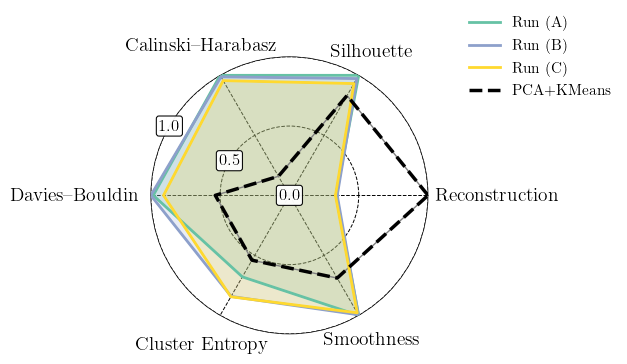

In [13]:
#df_plot = pd.concat([top3, df_kmeans], ignore_index=True)
from dataset import DataModule
import torch
from tqdm import tqdm

# DataModule und Validation-Loader
dm = DataModule(data_dir=file_path, batch_size=400, num_workers=8)
dm.setup()
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

baseline_raw, pca, scores_val = compute_pca_kmeans_baseline(
    gather_data(train_loader),
    gather_data(val_loader)
)
baseline_raw["exp_name"] = "PCA+KMeans"
df_kmeans = pd.DataFrame([baseline_raw])

#indices = [0, len(df_vae)//2, len(df_vae)-1]
indices=[28,9,67]
variances_df = df_vae.iloc[indices]

variances_df['exp_name'] = variances_df['exp_name'].replace({'Experiment_4': 'Run'})

version_map = {
    29: '(A)',
    10: '(B)',
    68: '(C)'
}
variances_df['version'] = (
    variances_df['version']
    .map(version_map)
    .fillna(variances_df['version'])
)

df_plot = pd.concat([variances_df, df_kmeans], ignore_index=True)

fixed_min = {
    "loss_recon":        0.2,
    "silhouette":        0.0,
    "calinski_harabasz": 0.0,
    "davies_bouldin":    2.5,
    "cluster_entropy":   1.6,
    "smoothness":       -1.0,  # falls deine Werte in diesem Bereich liegen
    "balance":          df_plot["balance"].min()
}

fixed_max = {
    "loss_recon":        df_plot["loss_recon"].min(),  # Oder festen Wert
    "silhouette":        df_plot["silhouette"].max(),
    "calinski_harabasz": df_plot["calinski_harabasz"].max(),
    "davies_bouldin":    df_plot["davies_bouldin"].min(),
    "cluster_entropy":   np.log(5),  # oder wie viele Cluster du hast
    "smoothness":        df_plot["smoothness"].max(),
    "balance":           df_plot["balance"].max()
}

invert_keys = [] #["loss_recon", "davies_bouldin"]

df_plot['exp_name'] = df_plot['exp_name'].str.replace("_", " ", regex=False)

df_radar_fixed = prepare_radar_df(
    df_plot,
    keys=metrics,
    invert_keys=invert_keys,
    fixed_min=fixed_min,
    fixed_max=fixed_max
)

metric_display = {
    "loss_recon": "Reconstruction",
    "silhouette": "Silhouette",
    "calinski_harabasz": "Calinski–Harabasz",
    "davies_bouldin": "Davies–Bouldin",
    "cluster_entropy": "Cluster Entropy",
    #"balance": "Cluster Blanace",
    "smoothness": "Smoothness",
}

plot_radar(df_radar_fixed, 
           keys=metrics, 
           metric_display=metric_display,
           label_radii = [1.5,1.2,1.25, 1.55, 1.25, 1.2]
          )#, title="Top-3 VAE + PCA/KMeans (fixe Skala)")

plt.savefig('./plots/Seed_Kmeans.pdf', bbox_inches='tight')


(<Figure size 600x360 with 1 Axes>, <PolarAxes: >)

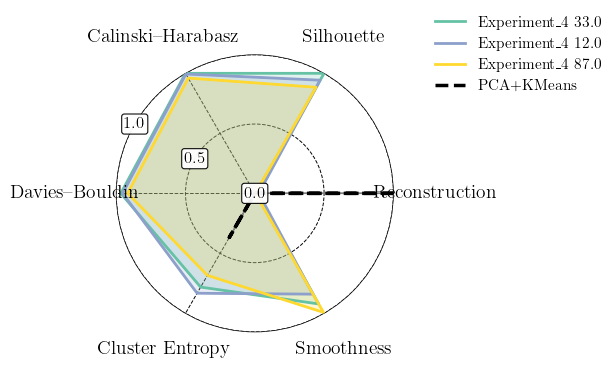

In [14]:
df_radar_normed = prepare_radar_df(
    df_vae,
    keys=metrics,
    invert_keys=["loss_recon", "davies_bouldin"],
    baseline_raw=baseline_raw
)

df_sorted = df_radar_normed.sort_values(
    by=["silhouette", "loss_recon"],
    ascending=[False, True]
)

top3 = df_sorted.head(3)
bottom1 = df_sorted.tail(1)

df_plot_normed = pd.concat([top3, bottom1], ignore_index = True)


plot_radar(df_plot_normed, keys=metrics, metric_display=metric_display)#, title="Top-3 VAE + PCA/KMeans (fixe Skala)")

In [15]:
# ZELLE 2: Parameter & Workflow mit JSON-Logs
import torch
import numpy as np
import json
import os
import pandas as pd
from dataset import DataModule

# --- 1) Baseline: PCA+KMeans + Latent-Smoothness ------------
file_path  = "/home/a/a271125/work/data/slp.N_djfm_6h_aac_detrend_1deg_north_atlantic.nc"
dm         = DataModule(data_dir=file_path, batch_size=400, num_workers=8)
dm.setup()
full       = gather_data(dm.all_data_dataloader())
val        = gather_data(dm.val_dataloader())

baseline_raw, pca, scores_val = compute_pca_kmeans_baseline(full, val)
scores_std = (scores_val - scores_val.mean(axis=0)) / (scores_val.std(axis=0) + 1e-10)
z          = torch.from_numpy(scores_std).float()
smooth, dv, gs = compute_smoothness(z, k=10)
baseline_raw.update({
    "latent_smoothness":   smooth,
    "density_variation":   dv,
    "gaussian_similarity": gs
})

# --- 2) RayTune-Logs aus JSON-Datei laden -------------------
json_path = "/work/aa0238/a271125/logs_ray/full_multi_vade/version_1/best_results/pareto_results.json"
with open(json_path, "r") as f:
    entries = json.load(f)

Loading data: 100%|██████████| 11/11 [00:00<00:00, 16.92it/s]


In [63]:
import os
import json
import numpy as np
import pandas as pd

# Passe diesen Pfad an:
interim_results_dir = "/work/aa0238/a271125/logs_ray/vae_gmm_multi_objective_scan/version_64/interim_results"

# Alle trial_*.json finden
trial_files = [f for f in os.listdir(interim_results_dir) if f.startswith("trial_") and f.endswith(".json")]

# --- 1.3) Ergebnisse aus allen Trials sammeln ---
entries = []
for f in trial_files:
    with open(os.path.join(interim_results_dir, f), "r") as file:
        entry = json.load(file)
        entries.append(entry)


(<Figure size 600x360 with 1 Axes>, <PolarAxes: >)

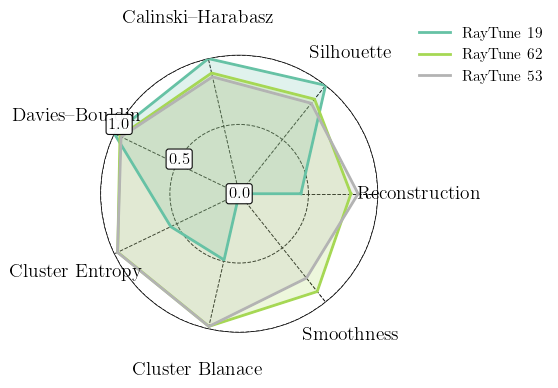

In [64]:
metric_display = {
    "loss_recon": "Reconstruction",
    "silhouette": "Silhouette",
    "calinski_harabasz": "Calinski–Harabasz",
    "davies_bouldin": "Davies–Bouldin",
    "cluster_entropy": "Cluster Entropy",
    "balance": "Cluster Blanace",
    "smoothness": "Smoothness",
}

# Hier werden alle gewünschten Keys definiert – inkl. smoothness
keys_rt = [
    "loss_recon",
    "silhouette",
    "calinski_harabasz",
    "davies_bouldin",
    "cluster_entropy",
    "balance",
    "smoothness",
]
records = []
for i, entry in enumerate(entries):
    m = entry["metrics"]
    # Für jeden Key: falls er im JSON-Block metrics steht, 
    # sonst np.nan
    rec = {k: float(m[k]) if k in m else np.nan for k in keys_rt}
    rec["exp_name"] = "RayTune"
    rec["version"]  = str(i)
    records.append(rec)

df_rt = pd.DataFrame(records)

# --- 3) Ausreißer filtern -----------------------------
# Nur auf jene Spalten filtern, die tatsächlich Werte haben
#mask = (
#    (df_rt["loss_recon"]        < 1e3)   &
#    (df_rt["silhouette"]        > -0.9)  &
#    (df_rt["calinski_harabasz"] > -0.1)  &
#    (df_rt["davies_bouldin"]    < 1e3)   &
#    (df_rt["cluster_entropy"]   > -0.1)  &
#    (df_rt["balance"]   > -1000)
#)
## Falls smoothness-Spalte nicht nur NaNs enthält, filtern wir auch darauf:
##if df_rt["smoothness"].notna().any():
##    mask &= (df_rt["smoothness"] > -0.1)
#
#df_rt = df_rt[mask].reset_index(drop=True)

# --- 4) Globale Normierungsgrenzen berechnen ----------
invert_keys = ["loss_recon", "davies_bouldin"]



df_rt_global = prepare_radar_df(
    df           = df_rt,
    keys         = keys_rt,
    invert_keys  = ["loss_recon", "davies_bouldin"],
    #baseline_raw = baseline_raw,
    #top_n        = 3
)

df_rt_sorted = df_rt_global.sort_values(
    by=["silhouette", "loss_recon"],
    ascending=[False, True]
)

#df_plot = pd.concat([df_rt_sorted.head(3), df_kmeans], ignore_index=True)

plot_radar(df_rt_sorted.head(3),
           keys_rt,
           metric_display,
           #label_radii = [1.5,1.12,1.5,1.4,1.13, 1.2, 1.2],# [reconstruction,silhouette,calinski,...]
          )
#plt.savefig('./plots/Pareto_RayTune_norm-.pdf', bbox_inches='tight')

In [65]:
df_rt_sorted

,loss_recon,silhouette,calinski_harabasz,davies_bouldin,cluster_entropy,balance,smoothness,exp_name,version,loss_recon_norm,silhouette_norm,calinski_harabasz_norm,davies_bouldin_norm,cluster_entropy_norm,balance_norm,smoothness_norm
19,0.072263,0.332004,150.785156,1.085968,1.360426,-240.701309,-1.021992,RayTune,19,0.445319,1.000000,1.000000,1.000000,0.547697,0.489698,0.000000
62,0.031181,0.290219,135.148041,1.332770,1.589568,-16.596563,-0.562800,RayTune,62,0.806173,0.872683,0.893407,0.954562,0.972774,0.981681,0.902862
53,0.025246,0.277708,131.007599,1.379968,1.590331,-16.275604,-0.626053,RayTune,53,0.858300,0.834562,0.865183,0.945872,0.974189,0.982386,0.778495
80,0.033063,0.277006,117.853401,1.382555,1.602962,-9.174087,-0.649832,RayTune,80,0.789637,0.832423,0.775516,0.945396,0.997621,0.997976,0.731741
49,0.031574,0.257455,103.432411,1.436996,1.376370,-239.078217,-0.591972,RayTune,49,0.802719,0.772852,0.677213,0.935373,0.577274,0.493261,0.845505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,0.044856,0.012417,6.434180,5.177096,1.420056,-119.453339,-0.611704,RayTune,16,0.686053,0.026223,0.016009,0.246792,0.658316,0.755877,0.806708
50,0.016524,0.012222,6.321812,5.430388,1.595325,-14.258651,-0.654160,RayTune,50,0.934917,0.025629,0.015243,0.200159,0.983453,0.986814,0.723231
8,0.020937,0.008456,6.575125,6.517573,1.505600,-123.604576,-0.669719,RayTune,8,0.896150,0.014153,0.016970,0.000000,0.817007,0.746764,0.692639
39,0.020047,0.006808,4.738160,6.044762,1.526416,-41.388683,-0.656177,RayTune,39,0.903970,0.009131,0.004448,0.087048,0.855623,0.927254,0.719265


In [66]:
df_rt_sorted, df_kmeans

(    loss_recon  silhouette  calinski_harabasz  davies_bouldin  \
 19    0.072263    0.332004         150.785156        1.085968   
 62    0.031181    0.290219         135.148041        1.332770   
 53    0.025246    0.277708         131.007599        1.379968   
 80    0.033063    0.277006         117.853401        1.382555   
 49    0.031574    0.257455         103.432411        1.436996   
 ..         ...         ...                ...             ...   
 16    0.044856    0.012417           6.434180        5.177096   
 50    0.016524    0.012222           6.321812        5.430388   
 8     0.020937    0.008456           6.575125        6.517573   
 39    0.020047    0.006808           4.738160        6.044762   
 38    0.013258    0.003811           4.085614        6.460347   
 
     cluster_entropy     balance  smoothness exp_name version  loss_recon_norm  \
 19         1.360426 -240.701309   -1.021992  RayTune      19         0.445319   
 62         1.589568  -16.596563   -0.5628

In [67]:
df_rt_sorted = df_records.sort_values(
    by=["silhouette", "loss_recon"],
    ascending=[False, True]
)

#df_plot = pd.concat([df_rt_sorted.head(3), df_kmeans], ignore_index=True)
df_plot = df_rt_sorted.head(3)


fixed_min = {
    "loss_recon":        0.023,
    "silhouette":        0.0,
    "calinski_harabasz": 0.0,
    "davies_bouldin":    2.5,
    "cluster_entropy":   0.0,
    "smoothness":       -1.0,
    "balance":          -300,
}

fixed_max = {
    "loss_recon":        0.05,  # Oder festen Wert
    "silhouette":        0.3,
    "calinski_harabasz": 200,
    "davies_bouldin":    0,
    "cluster_entropy":   np.log(5),  # oder wie viele Cluster du hast
    "smoothness":        0.0,
    "balance":           0,
}

df_plot_rt_fixed = prepare_radar_df(
    df           = df_plot,
    keys         = keys_rt,
    invert_keys  = [],#invert_keys,
    #top_n        = 3,
    #baseline_raw = None,
    fixed_min    = fixed_min,
    fixed_max    = fixed_max
)
plot_radar(df_plot_rt_fixed,
           keys_rt,
           metric_display,
           #label_radii = [1.5,1.12,1.5,1.4,1.13],
          )#, title="Top-3 RayTune (fixed)")
#plt.savefig('./plots/Pareto_RayTune_fix.pdf', bbox_inches='tight')

NameError: name 'df_records' is not defined

Loading data: 100%|██████████| 11/11 [00:00<00:00, 17.28it/s]


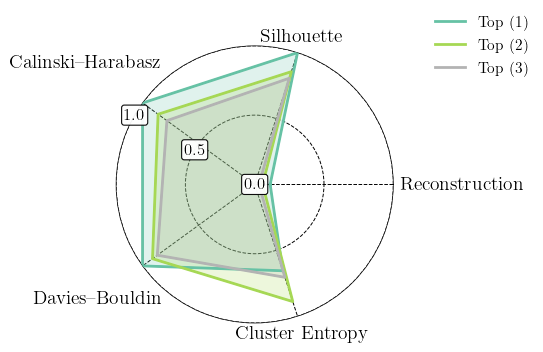

In [81]:


# ZELLE 2: Parameter & Workflow mit JSON-Logs
import torch
import numpy as np
import json
import os
import pandas as pd
from dataset import DataModule

# --- 1) Baseline: PCA+KMeans + Latent-Smoothness ------------
file_path  = "/home/a/a271125/work/data/slp.N_djfm_6h_aac_detrend_1deg_north_atlantic.nc"
dm         = DataModule(data_dir=file_path, batch_size=400, num_workers=8)
dm.setup()
full       = gather_data(dm.all_data_dataloader())
val        = gather_data(dm.val_dataloader())

baseline_raw, pca, scores_val = compute_pca_kmeans_baseline(full, val)
scores_std = (scores_val - scores_val.mean(axis=0)) / (scores_val.std(axis=0) + 1e-10)
z          = torch.from_numpy(scores_std).float()
smooth, dv, gs = compute_smoothness(z, k=10)
baseline_raw.update({
    "latent_smoothness":   smooth,
    "density_variation":   dv,
    "gaussian_similarity": gs
})

# --- 2) RayTune-Logs aus JSON-Datei laden -------------------
json_path = "/work/aa0238/a271125/logs_ray/full_multi_vade/version_1/best_results/pareto_results.json"
with open(json_path, "r") as f:
    entries = json.load(f)

# Hier werden alle gewünschten Keys definiert – inkl. smoothness
keys_rt = [
    "loss_recon",
    "silhouette",
    "calinski_harabasz",
    "davies_bouldin",
    "cluster_entropy",
    #"smoothness",           # neu
]
records = []
for i, entry in enumerate(entries):
    m = entry["metrics"]
    # Für jeden Key: falls er im JSON-Block metrics steht, 
    # sonst np.nan
    rec = {k: float(m[k]) if k in m else np.nan for k in keys_rt}
    rec["exp_name"] = "RayTune"
    rec["version"]  = str(i)
    records.append(rec)

df_rt = pd.DataFrame(records)

# --- 3) Ausreißer filtern -----------------------------
# Nur auf jene Spalten filtern, die tatsächlich Werte haben
mask = (
    (df_rt["loss_recon"]       < 1e3)   &
    (df_rt["silhouette"]       > -0.9) &
    (df_rt["calinski_harabasz"] > -0.1)&
    (df_rt["davies_bouldin"]    < 1e3)  &
    (df_rt["cluster_entropy"]   > -0.1)
)
# Falls smoothness-Spalte nicht nur NaNs enthält, filtern wir auch darauf:
#if df_rt["smoothness"].notna().any():
#    mask &= (df_rt["smoothness"] > -0.1)

df_rt = df_rt[mask].reset_index(drop=True)

# --- 4) Globale Normierungsgrenzen berechnen ----------
gmin_rt = df_rt[keys_rt].min().to_dict()
gmax_rt = df_rt[keys_rt].max().to_dict()

invert_keys = ["loss_recon", "davies_bouldin"]


df_rt_global = prepare_radar_df(
    df           = df_rt,
    keys         = keys_rt,
    invert_keys  = ["loss_recon", "davies_bouldin"],
    baseline_raw = None,
)

# 1) Kopie sicherstellen
top3 = (
    df_rt_global
      .sort_values(by=["silhouette","loss_recon"], ascending=[False,True])
      .head(3)
      .copy()
)

# 2) exp_name ersetzen
top3.loc[:, 'exp_name'] = top3['exp_name'].replace({'RayTune': 'Top'})

# 3) version als Strings mappen
version_map_str = {
    '6':  '(1)',
    '28': '(2)',
    '30': '(3)'
}
top3.loc[:, 'version'] = top3['version'].replace(version_map_str)
# 5) exp_name ebenfalls sauber ersetzen
top3['exp_name'] = top3['exp_name'].replace({'Experiment_4': 'Top'})

# 7) Dann erst plotten
fig, ax = plot_radar(
    top3,
    keys_rt,
    metric_display,
    label_radii=[1.5,1.12,1.5,1.4,1.13],
)
plt.savefig('./plots/Pareto_RayTune_norm.pdf', bbox_inches='tight')
plt.show()


In [74]:
top3

,loss_recon,silhouette,calinski_harabasz,davies_bouldin,cluster_entropy,exp_name,version,loss_recon_norm,silhouette_norm,calinski_harabasz_norm,davies_bouldin_norm,cluster_entropy_norm
6,0.022118,0.102226,35.952450,2.208251,1.583442,RayTune,6,0.111572,1.000000,1.000000,1.000000,0.654944
27,0.022294,0.094987,33.881645,2.265508,1.597902,RayTune,28,0.057349,0.855577,0.861601,0.911391,0.888722
29,0.022377,0.092481,32.705612,2.293012,1.586511,RayTune,30,0.031391,0.805582,0.783003,0.868826,0.704560


In [ ]:
import json

with open("./cache_df/cluster_structures.json") as f:
    cluster_map_raw = json.load(f)

# Jetzt als Lookup-Table: (exp_name, version) -> mapping
cluster_map = {}
for key, v in cluster_map_raw.items():
    # Key-Splitting: "Exp_400Epochs_v1" → "Exp_400Epochs", 1
    exp_name, version = key.rsplit('_v', 1)
    cluster_map[(exp_name, int(version))] = {int(i): name for i, name in v.items()}

    
    
def get_cluster_names(row):
    return cluster_map.get((row['exp_name'], int(row['version'])), {})

df_vae['cluster_names'] = df_vae.apply(get_cluster_names, axis=1)

# Jetzt pro Cluster-ID eigene Spalte:
for cluster_idx in range(5):  # oder range(n_clusters)
    df_vae[f'cluster_{cluster_idx}_name'] = df_vae['cluster_names'].apply(lambda d: d.get(cluster_idx, None))


In [ ]:
df_vae['cluster_combo'] = df_vae[[f'cluster_{i}_name' for i in range(5)]].agg('|'.join, axis=1)
# Jetzt kannst du alle einzigartigen Clusterkonstellationen und deren Häufigkeit anzeigen:
print(df_vae['cluster_combo'].value_counts())


In [ ]:
import seaborn as sns
df = df_vae.copy()

# Erstelle die Zielvariable
df['has_EU'] = df[[f'cluster_{i}_name' for i in range(5)]].apply(lambda row: 'EU' in row.values, axis=1)

# Pairplot einfärben nach has_EU
sns.pairplot(df, hue='has_EU', vars=['silhouette', 'calinski_harabasz', 'davies_bouldin', 'loss_recon', 'smoothness', "cluster_balance", "cluster_entropy"])


In [ ]:
import scipy.stats as stats

metriken = ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'loss_recon', 'smoothness', "cluster_balance", "cluster_entropy"]

for metrik in metriken:
    group_EU = df[df["has_EU"] == True][metrik]
    group_noEU = df[df["has_EU"] == False][metrik]

    # t-Test (für Normalverteilung)
    # Mann-Whitney-U-Test
    u_stat, p_value = stats.mannwhitneyu(group_EU, group_noEU)

    print("p-Wert:", p_value)


    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.violinplot(x="has_EU", y=metrik, data=df)
    plt.show()


In [ ]:
for i in range(5):
    print(f"\nCluster-{i}-Häufigkeiten:")
    print(df_vae[f'cluster_{i}_name'].value_counts())


In [ ]:
import json

mapping = {
    "Exp_400Epochs_v1":  {0: "NAO+", 1: "NAO-", 2: "ATL-", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v2":  {0: "NAO+", 1: "NAO-", 2: "ATL-", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v3":  {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v4":  {0: "NAO+", 1: "NAO-", 2: "ATL-", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v5":  {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v6":  {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v7":  {0: "NAO+", 1: "NAO-", 2: "URAL", 3: "DIPOL", 4: "O-SCAN"},
    "Exp_400Epochs_v8":  {0: "NAO+", 1: "NAO-", 2: "ATL-", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v9":  {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v10": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v11": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v12": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v13": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v14": {0: "NAO+", 1: "NAO-", 2: "ATL-", 3: "DIPOL", 4: "SCAN"},#?
    "Exp_400Epochs_v15": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v16": {0: "NAO+", 1: "NAO-", 2: "ATL-", 3: "DIPOL", 4: "SCAN"},#?
    "Exp_400Epochs_v17": {0: "NAO+", 1: "NAO-", 2: "ATL-", 3: "DIPOL", 4: "SCAN"},#?
    "Exp_400Epochs_v18": {0: "NAO+", 1: "NAO-", 2: "ATL-", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v19": {0: "NAO+", 1: "NAO-", 2: "ATL-", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v20": {0: "NAO+", 1: "NAO-", 2: "ATL-", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v21": {0: "NAO+", 1: "NAO-", 2: "ATL-", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v22": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v23": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v24": {0: "NAO+", 1: "NAO-", 2: "ATL-", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v25": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v26": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v27": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v28": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v29": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},#??
    "Exp_400Epochs_v30": {0: "NAO+", 1: "NAO-", 2: "ATL-", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v31": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v32": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v33": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v34": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v35": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v36": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},#?
    "Exp_400Epochs_v37": {0: "NAO+", 1: "NAO-", 2: "ATL-", 3: "DIPOL", 4: "SCAN"},#??
    "Exp_400Epochs_v38": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v39": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},#?
    "Exp_400Epochs_v40": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v41": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v42": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v43": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v44": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v45": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v46": {0: "NAO+", 1: "NAO-", 2: "ATL-", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v47": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v48": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
    "Exp_400Epochs_v49": {0: "NAO+", 1: "NAO-", 2: "EU", 3: "DIPOL", 4: "SCAN"},
}


# Schlüssel zu str casten für JSON-Kompatibilität:
mapping_str_keys = {k: {str(ck): v for ck, v in clustermap.items()} for k, clustermap in mapping.items()}

with open("./cache_df/cluster_structures.json", "w") as f:
    json.dump(mapping_str_keys, f, indent=2)
